In [1]:
import astropy.units as u
import numpy as np
import copy

from ctapipe.utils.datasets import get_dataset_path

from ctapipe.io import event_source
from ctapipe.calib import CameraCalibrator
from ctapipe.reco import HillasReconstructor
from ctapipe.visualization import CameraDisplay, ArrayDisplay

from ctapipe.image.timing_parameters import timing_parameters
from ctapipe.image import tailcuts_clean, hillas_parameters, dilate


import matplotlib.pyplot as plt
%matplotlib inline

/home/lnickel/.local/anaconda3/envs/cta/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [3]:
class HillasNotFinite(Exception):
    """
    Error to be raised when hillas parameters are not finite
    """ 
    pass

def cleaning(event):
    
    cal.calibrate(event)
    
    features = {}
    hillas_dict = {}
    pointing_azimuth = {}
    pointing_altitude = {}
    
    for tel_id in event.r0.tels_with_data:
        dl1 = event.dl1.tel[tel_id]
        camera = event.inst.subarray.tels[tel_id].camera
        mask = tailcuts_clean(camera, dl1.image[0], 
                              boundary_thresh=5, 
                              picture_thresh=10, 
                              min_number_picture_neighbors=2)
        
        telescope_type_name = event.inst.subarray.tels[tel_id].optics.tel_type
        dl1.cleaned = copy.copy(dl1.image[0])
        cleaned = dl1.cleaned
        cleaned[~mask] = 0
        
        if cleaned.sum() > 0:
            try:
                h = hillas_parameters(camera,
                                      cleaned)
                if not all(map(np.isfinite, h.values())):
                    raise HillasNotFinite("bad Hillas parameters")
                    
                hillas_dict[tel_id] = h
                pointing_azimuth[tel_id] = event.mcheader.run_array_direction[0]
                pointing_altitude[tel_id] = event.mcheader.run_array_direction[1]
            except HillasNotFinite:
                pass
        else:
            pass

    return None


In [4]:
#filename = get_dataset_path("gamma_test.simtel.gz")
filename = get_dataset_path("gamma_test_large.simtel.gz")
source = event_source(filename)


#layout = np.loadtxt('CTA.prod3Sb.3HB9-FG.lis', usecols=0, dtype=int)

#layout = set(layout)

source = event_source(filename)
source.max_events = 50
#source.allowed_tels = layout
events = [copy.deepcopy(event) for event in source]

In [5]:
# THIS BLOCK IS FOR FILES DIFFERENT FROM THOSE PROVIDED AS EXAMPLE

#filename = 'proton_20deg_0deg_run24___cta-prod3_desert-2150m-Paranal-merged.simtel.gz'
#layout = np.loadtxt('CTA.prod3Sb.3HB9-FG.lis', usecols=0, dtype=int)

#filename = 'gamma_20deg_0deg_run100___cta-prod3-lapalma3-2147m-LaPalma_cone10.simtel.gz'
#filename = 'gamma_20deg_0deg_run100___cta-prod3_desert-2150m-Paranal-merged.simtel.gz'
#filename = 'gamma_20deg_0deg_run118___cta-prod3_desert-2150m-Paranal-merged_cone10.simtel.gz'
#filename = 'gamma_20deg_180deg_run11___cta-prod3_desert-2150m-Paranal-merged_cone10.simtel.gz'

#layout = np.loadtxt('CTA.prod3Sb.3HB9-FG.lis', usecols=0, dtype=int)

#layout = set(layout)

#source = event_source(filename)
#source.max_events = 50
#source.allowed_tels = layout
#events = [copy.deepcopy(event) for event in source]

In [6]:
# Calibration
cal = CameraCalibrator(None, None, r1_product='HESSIOR1Calibrator', extractor_product='NeighbourPeakIntegrator')
for event in events:
    cal.calibrate(event)

event = events[3]

print(len(event.r0.tels_with_data))

cleaning(event)


17


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16


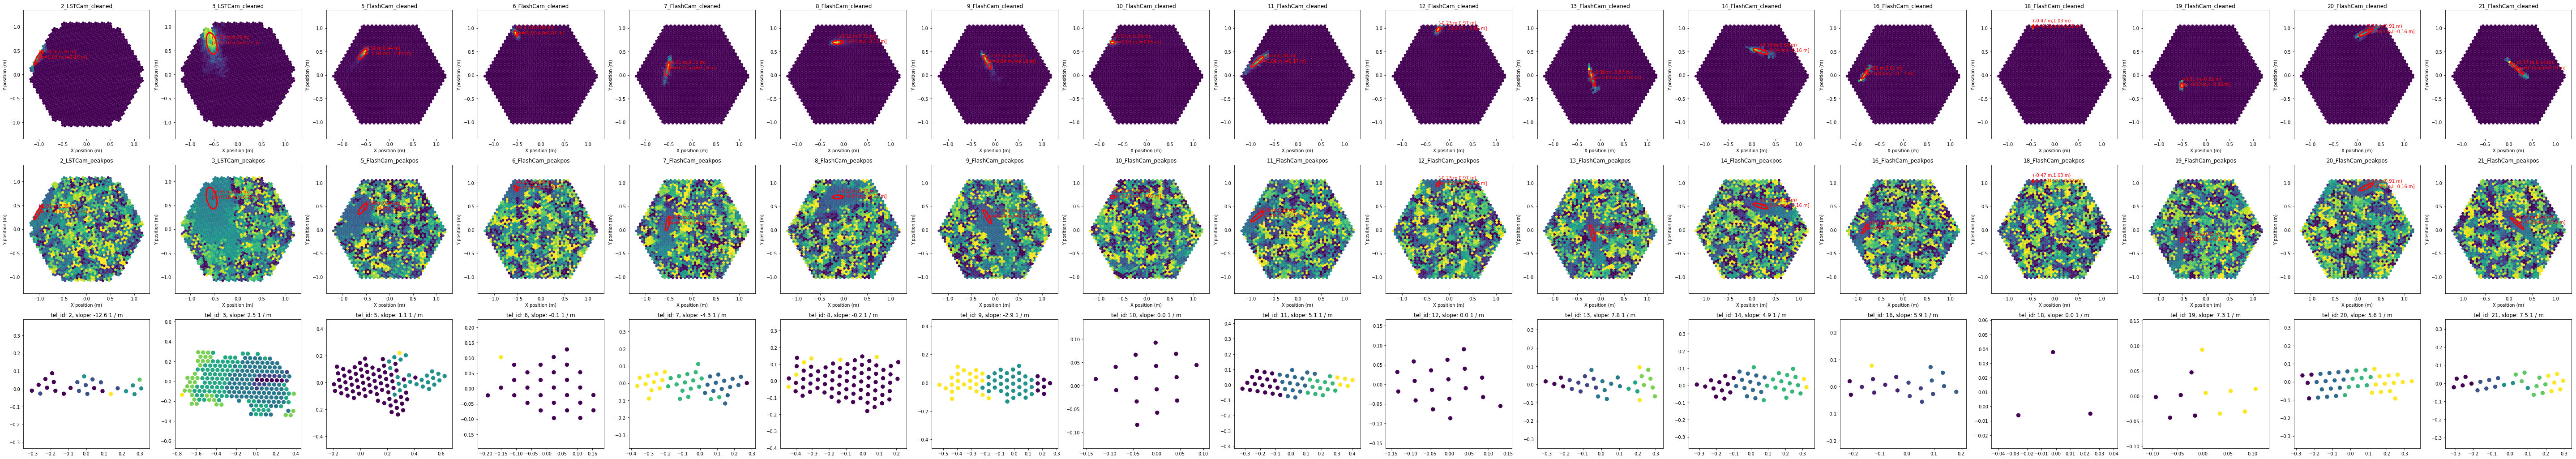

In [13]:
ncol = len(event.r0.tels_with_data)
nrow = 3 * (len(event.r0.tels_with_data)//ncol + 1 * (len(event.r0.tels_with_data)%ncol > 0))
fs = 6

fig, axes = plt.subplots(nrow, ncol, figsize=(fs*ncol, fs*nrow))

hillas_dict = {}
arrow_reverse = {}

for ii, tel_id in enumerate(event.r0.tels_with_data):
    print(ii)
    camera = event.inst.subarray.tel[tel_id].camera
    pos_x = camera.pix_x
    pos_y = camera.pix_y

    image = event.dl1.tel[tel_id].image[0]
    cleaned = event.dl1.tel[tel_id].cleaned
    peakpos = event.dl1.tel[tel_id].peakpos[0]
    
    disp = CameraDisplay(camera, cleaned, ax = axes.ravel()[ii])
    disp.axes.set_title("{0}_{1}_cleaned".format(str(tel_id), disp.geom.cam_id))
    
    disp_time = CameraDisplay(camera, peakpos, ax = axes.ravel()[ii + len(event.r0.tels_with_data)])
    disp_time.axes.set_title("{0}_{1}_peakpos".format(str(tel_id), disp.geom.cam_id))

    rotation_cleaned = axes.ravel()[ii + 2*len(event.r0.tels_with_data)]

    if cleaned.sum() > 0:
        hillas = hillas_parameters(camera, cleaned)
        hillas_dict[tel_id] = hillas
        disp.overlay_moments(hillas, color='RED', linewidth=3, zorder=10)
        disp_time.overlay_moments(hillas, color='RED', linewidth=3, zorder=10)

        mask = np.ma.masked_where(cleaned > 0, cleaned).mask
        
        pos_x_sel = pos_x[mask] 
        pos_y_sel = pos_y[mask] 
        img_sel = image[mask]

        peakpos_sel = peakpos[mask]



        longi, trans = camera.get_shower_coordinates(
            hillas.x,
            hillas.y,
            hillas.psi
        )
        t_par = timing_parameters(camera[mask], img_sel, peakpos=peakpos_sel, hillas_parameters=hillas)
        arrow_reverse[tel_id] = t_par.slope.value                
        rotation_cleaned.axes.set_title("tel_id: {0}, slope: {1:.1f}".format(tel_id, t_par.slope))

        rotation_cleaned.scatter(longi[mask], trans[mask], c = peakpos_sel, s = 70)
        rotation_cleaned.axis('equal')
        
        
plt.show()

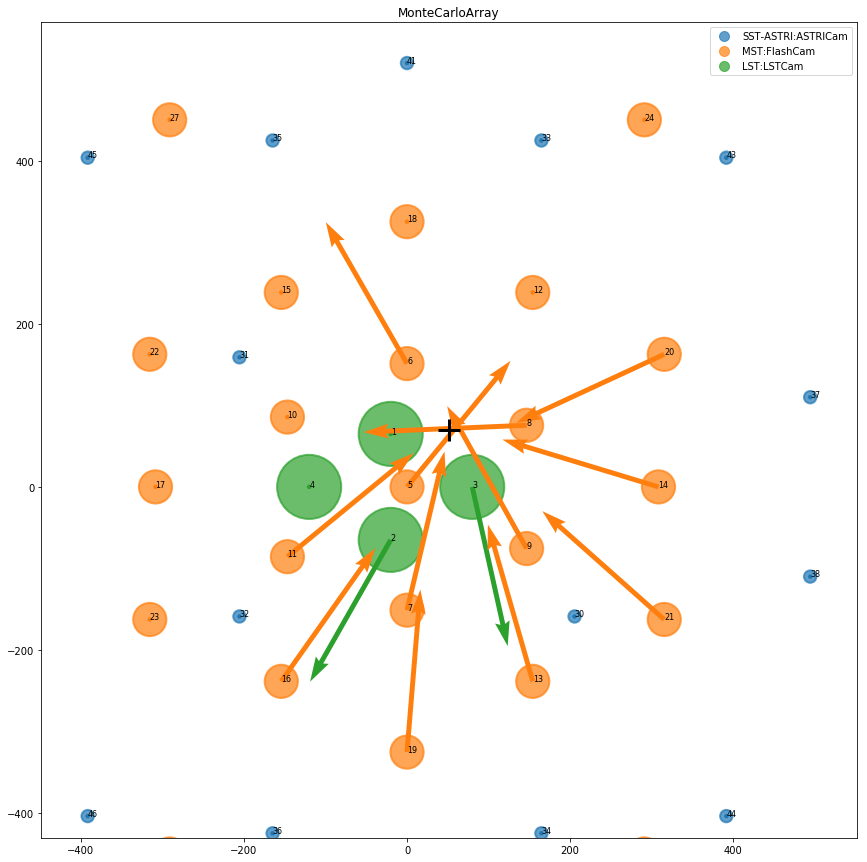

In [14]:
plt.figure(figsize=(15,15))

angle_off = event.mcheader.run_array_direction[0]

# TO BE USED FOR EXAMPLE FILES IN CTAPIPE
array = ArrayDisplay(event.inst.subarray)

# UNCOMMENT THIS FOR OTHER FILES OTHER THAN THOSE IN CTAPIPE
#array = ArrayDisplay(event.inst.subarray.select_subarray("Paranal", layout))

array.add_labels()
array.set_vector_hillas(hillas_dict = hillas_dict, length = 200, time_gradient = arrow_reverse, angle_offset=angle_off)
#array.set_line_hillas(hillas_dict, range = 800, linewidth=2)
plt.scatter(event.mc.core_x, event.mc.core_y, marker = '+', color='black', s=500, linewidth=3, label="Event impact")

limit = 500
plt.xlim((event.mc.core_x.value - limit, event.mc.core_x.value + limit))
plt.ylim((event.mc.core_y.value - limit, event.mc.core_y.value + limit))
plt.savefig("arrow_test.png")
plt.show()